In [1]:
import numpy as np
from collections import deque
from collections import defaultdict
import pyvista as pv
pv.set_jupyter_backend('static')

In [2]:
vertices_file = 'vertices.txt'
triangles_file = 'triangles.txt'
vertices = np.loadtxt(vertices_file)
faces = np.loadtxt(triangles_file, dtype=int) - 1
faces = np.sort(faces, axis=1)

In [3]:
print(vertices)

[[ -1.2137984  -17.10070125   3.587021  ]
 [ -2.6703557  -15.66068165   0.0886761 ]
 [ -6.0689906  -17.39874495  -2.4083613 ]
 ...
 [-18.206972    -4.14140675  31.1733985 ]
 [-13.4693731   -4.37652375  34.7598015 ]
 [-13.9978332   -7.70610975  33.5924425 ]]


In [4]:
print(faces)

[[ 255  258  262]
 [ 255  262  263]
 [ 261  262  263]
 ...
 [ 969 1008 1018]
 [ 246  247  289]
 [1777 1778 1781]]


This function iterates through a set of triangles, updating a count of how many times each edge appears. The first two columns describe each edge, while the last column tracks its frequency of occurrence.

In [5]:
def edge_array(faces):
    edges_count = {}

    for face in faces:
        v1, v2, v3 = face
        edges = [tuple(sorted((v1, v2))), tuple(sorted((v2, v3))), tuple(sorted((v3, v1)))]

        for edge in edges:
            if edge in edges_count:
                edges_count[edge] += 1
            else:
                edges_count[edge] = 1
    
    edges = np.array([(edge[0], edge[1], count) for edge, count in edges_count.items()])
    print(edges)
    return edges

In [6]:
edges = edge_array(faces)

[[ 255  258    2]
 [ 258  262    2]
 [ 255  262    2]
 ...
 [ 459 1720    2]
 [ 458  460    2]
 [ 498  499    1]]


In [7]:
edges_1=edges[edges[:, 2] == 1]
edges_3=edges[edges[:, 2] > 2]
print("edges used in 1 triangle " ,edges_1)
print("edges used in more than 2 triangles" ,edges_3)

edges used in 1 triangle  [[  90  263    1]
 [  90   94    1]
 [  94  263    1]
 [ 341 1256    1]
 [ 348 1256    1]
 [ 341  348    1]
 [ 498  501    1]
 [ 499  501    1]
 [ 498  499    1]]
edges used in more than 2 triangles []


a) there are 9 edges so which are used in 1 triangle

b) no edge is used in more than 2 triangles

THIS IS A 2 MANIFOLD WITH BOUNDRY

In [8]:
v = np.unique(faces).shape[0]
print(v)

1928


In [9]:
f = faces.shape[0]
print(f)

3853


In [10]:
e = edges.shape[0]
print(e)

5784


In [11]:
euler_number = v-e+f
print(euler_number)

-3


In this case, we can gather the nine edges that are used exclusively in one triangle and organize them into a cohesive set, which we can then utilize to form new triangles independently without disturbing anything else

In [12]:
new_triangles = np.array([
    [90, 94, 263],
    [341, 348, 1256],
    [499, 498, 501]
]) 

faces_update = np.vstack((faces, new_triangles))
print(faces_update)

[[ 255  258  262]
 [ 255  262  263]
 [ 261  262  263]
 ...
 [  90   94  263]
 [ 341  348 1256]
 [ 499  498  501]]


In [13]:
edges_update = edge_array(faces_update)

[[ 255  258    2]
 [ 258  262    2]
 [ 255  262    2]
 ...
 [ 459 1720    2]
 [ 458  460    2]
 [ 498  499    2]]


In [14]:
edges_u_1=edges_update[edges_update[:, 2] == 1]
print(edges_u_1)
print(edges_update.shape[0])

[]
5784


The new euler number after adding the new triangles will be the old one plus 3 as we did not disturb anything other than adding the 3 new faces

In [15]:
new_euler_number = euler_number + 3
print(new_euler_number)

0


In [16]:
def convert_triangles(triangles, edges):
    from collections import defaultdict
    
    adjacency_list = defaultdict(list)
    
    edge_to_triangles = defaultdict(list)
    
    for i, triangle in enumerate(triangles, start=1):  
        edges_of_triangle = [tuple(sorted((triangle[0], triangle[1]))),
                             tuple(sorted((triangle[1], triangle[2]))),
                             tuple(sorted((triangle[2], triangle[0])))]
        
        for edge in edges_of_triangle:
            edge_to_triangles[edge].append(i)
    
    for edge, tris in edge_to_triangles.items():
        if len(tris) == 2:
            t1, t2 = tris
            adjacency_list[t1].append(t2)
            adjacency_list[t2].append(t1)
    
    for i in range(1, len(triangles) + 1):  
        if i not in adjacency_list:
            adjacency_list[i] = []
    
    return adjacency_list



In [17]:
tri = convert_triangles(faces_update,edges_update)

In [18]:

import numpy as np
from collections import deque

def is_orientable(tri, triangles_update):
    def opposite_orientation(tri1, tri2):
        """Check if tri2 has the opposite orientation of tri1"""
        for i in range(3):
            for j in range(3):
                if tri1[i] == tri2[j] and tri1[(i+1)%3] == tri2[(j+2)%3]:
                    return True
        return False

    visited = {}
    queue = deque([1])
    visited[1] = triangles_update[0] 

    print(f"Starting BFS with triangle {visited[1]} as the initial orientation.")

    while queue:
        current = queue.popleft()
        current_tri = visited[current]

        print(f"Visiting triangle {current}: {current_tri}")

        for neighbor in tri[current]:
            if neighbor in visited:
                neighbor_tri = visited[neighbor]
                if not opposite_orientation(current_tri, neighbor_tri):
                    print(f"Orientation mismatch found between triangle {current} and {neighbor}.")
                    return False
                else:
                    print(f"Triangle {neighbor} already visited and correctly oriented.")
            else:
                neighbor_tri = triangles_update[neighbor-1]
                common_edge = np.intersect1d(current_tri, neighbor_tri)

                print(f"Common edge between triangle {current} and {neighbor}: {common_edge}")

                idx_current_1, idx_current_2 = np.where(current_tri == common_edge[:, None])[1]
                idx_neighbor_1, idx_neighbor_2 = np.where(neighbor_tri == common_edge[:, None])[1]

                if not opposite_orientation(current_tri, neighbor_tri):
                    neighbor_tri[idx_neighbor_1], neighbor_tri[idx_neighbor_2] = neighbor_tri[idx_neighbor_2], neighbor_tri[idx_neighbor_1]

                visited[neighbor] = neighbor_tri
                queue.append(neighbor)
                print(f"Triangle {neighbor} oriented as {visited[neighbor]} and added to queue.")

    print("All triangles oriented consistently.")
    return True


In [19]:
orientability = is_orientable(tri,faces_update)
print("orientability ", orientability)

Starting BFS with triangle [255 258 262] as the initial orientation.
Visiting triangle 1: [255 258 262]
Common edge between triangle 1 and 9: [255 258]
Triangle 9 oriented as [254 258 255] and added to queue.
Common edge between triangle 1 and 22: [258 262]
Triangle 22 oriented as [258 260 262] and added to queue.
Common edge between triangle 1 and 2: [255 262]
Triangle 2 oriented as [255 262 263] and added to queue.
Visiting triangle 9: [254 258 255]
Triangle 1 already visited and correctly oriented.
Common edge between triangle 9 and 10: [254 255]
Triangle 10 oriented as [ 89 254 255] and added to queue.
Common edge between triangle 9 and 14: [254 258]
Triangle 14 oriented as [254 257 258] and added to queue.
Visiting triangle 22: [258 260 262]
Triangle 1 already visited and correctly oriented.
Common edge between triangle 22 and 21: [260 262]
Triangle 21 oriented as [118 262 260] and added to queue.
Common edge between triangle 22 and 23: [258 260]
Triangle 23 oriented as [258 259 2

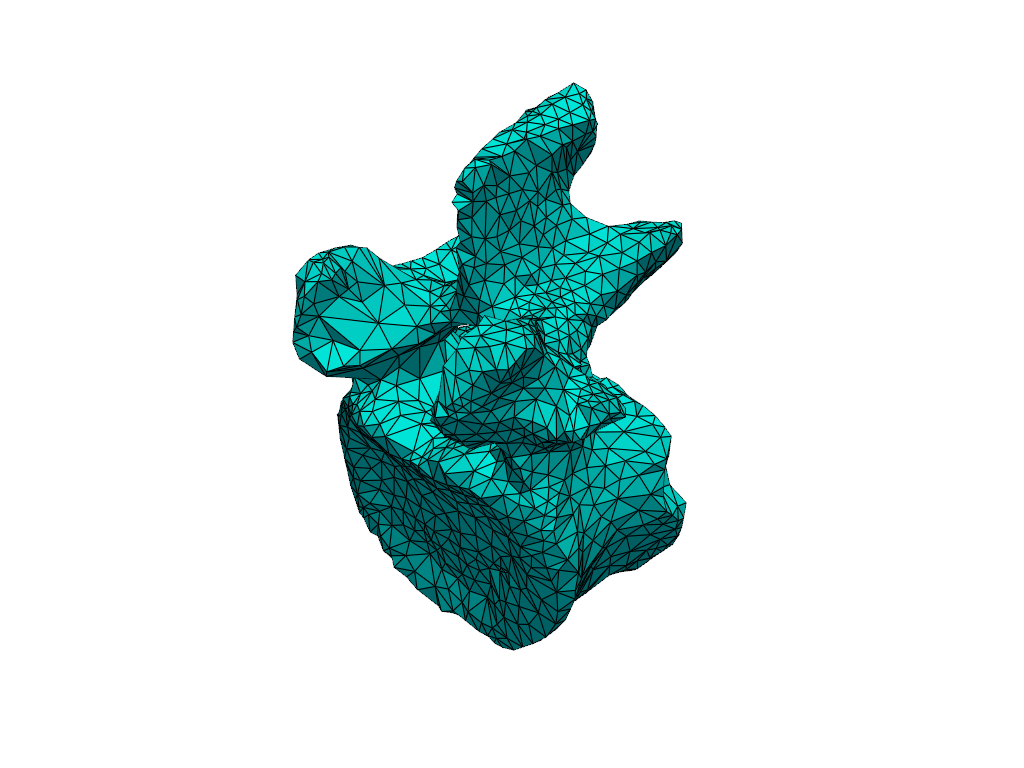

In [20]:
faces = np.hstack([[3, *face] for face in faces_update])

mesh = pv.PolyData(vertices, faces)

plotter = pv.Plotter()
plotter.add_mesh(mesh, color='cyan', show_edges=True)
plotter.show()

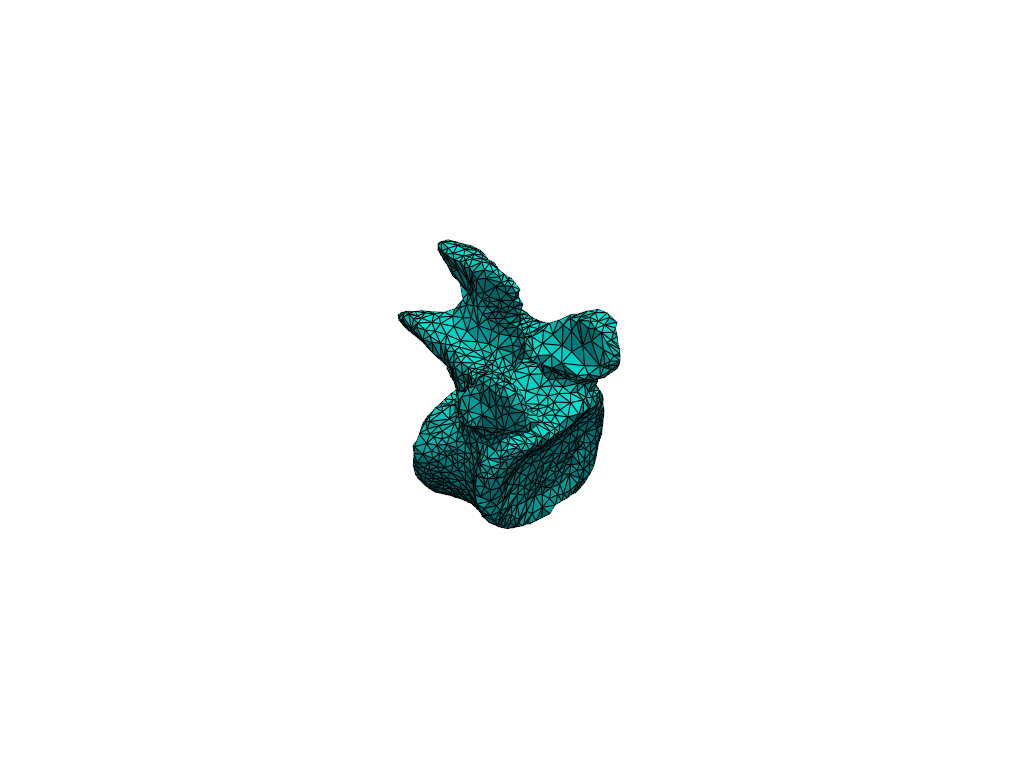

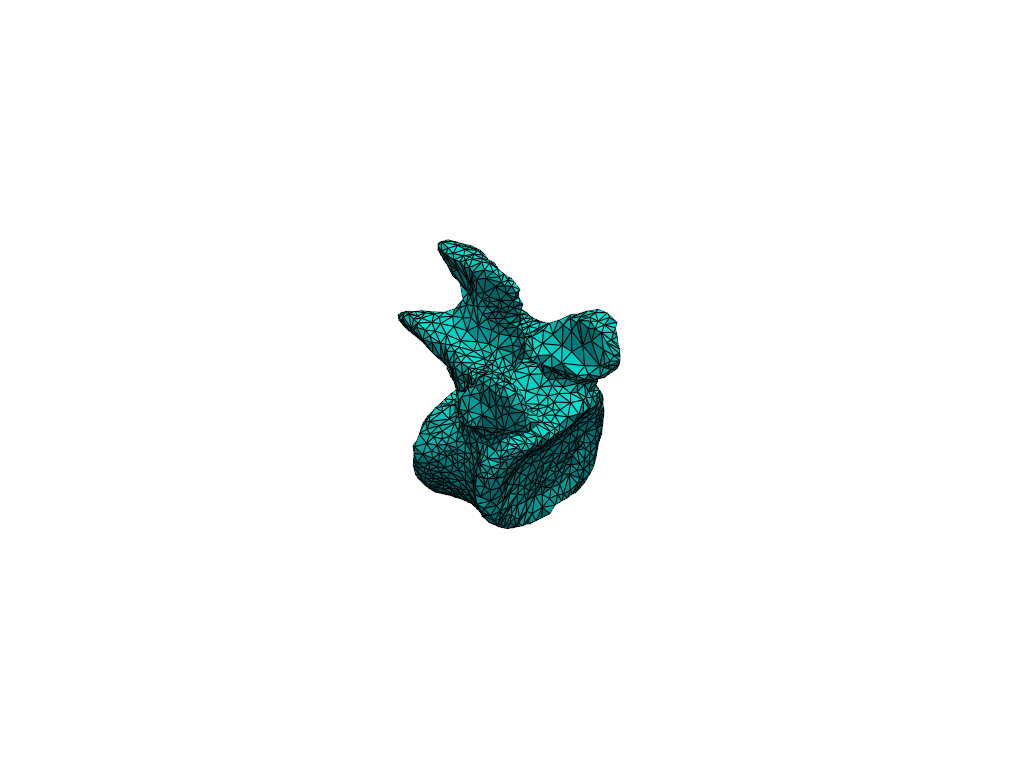

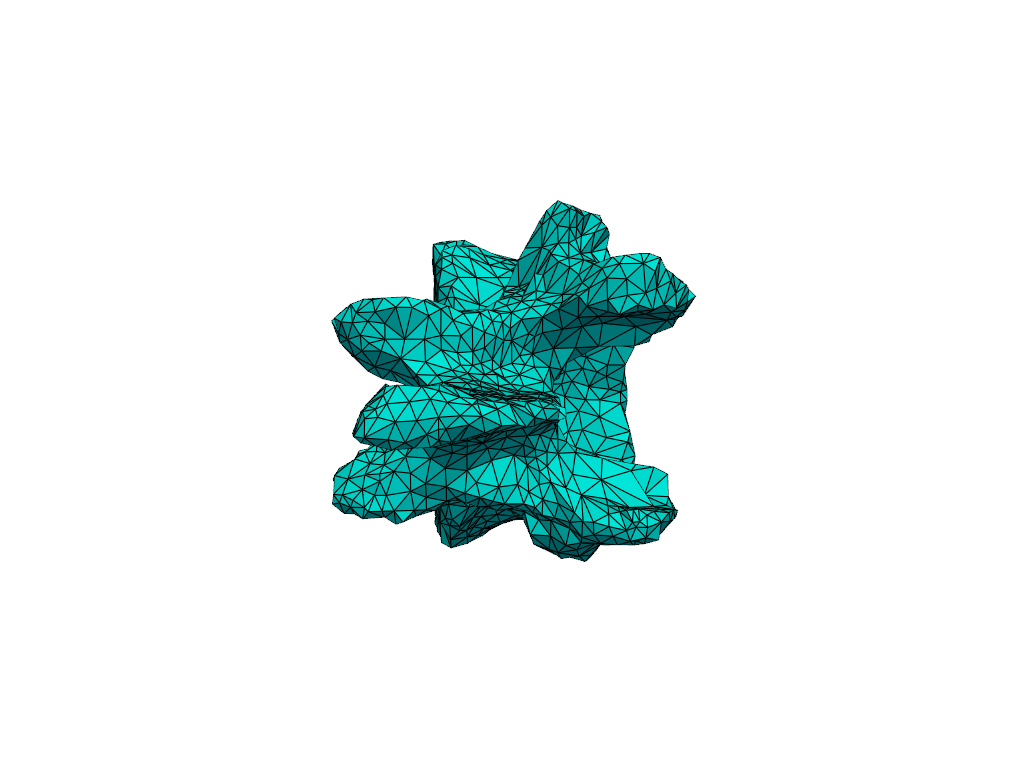

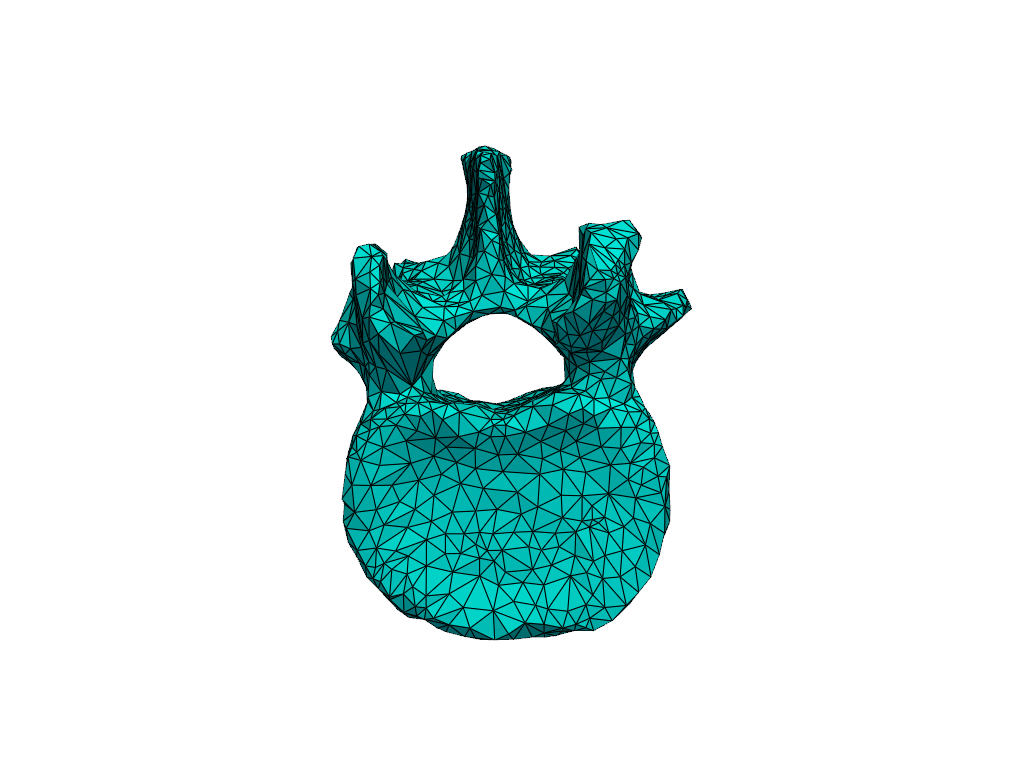

In [21]:
faces = np.hstack([[3, *face] for face in faces_update])

mesh = pv.PolyData(vertices, faces)

plotter = pv.Plotter()
plotter.add_mesh(mesh, color='cyan', show_edges=True)
views = {
    "isometric": [(200, -200, 200), (0, 0, 0), (0, 0, 1)],
    "front": [(0, 0, 200), (0, 0, 0), (0, 1, 0)],
    "side": [(200, 0, 0), (0, 0, 0), (0, 0, 1)],
    "top": [(0, 200, 0), (0, 0, 0), (0, 0, 1)]
}

for view_name, view_position in views.items():
    plotter.camera_position = view_position
    screenshot = plotter.screenshot(f"{view_name}.png")
    plotter.show(auto_close=False)

plotter.close()